In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"
#down the pytorch version for avoiding error

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 31.8MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from fastai.vision import *

In [ ]:
# import torch.utils.data
# from torch.utils.data import Dataset, DataLoader
# import torchvision
# from torchvision import transforms

In [ ]:
# import fastai
# fastai.__version__

'1.0.61'

## Data

We are going to use the [Pascal dataset](http://host.robots.ox.ac.uk/pascal/VOC/) for object detection. There is a version from 2007 and a bigger version from 2012. We'll use the 2007 version here. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir('gdrive/MyDrive')
!ls

Mounted at /content/gdrive
 arbitaryset	   'PeopleSpace_limsungjun(Sam)_assignment1 (1).pdf'   sample
 coco_tiny	   'PeopleSpace_limsungjun(Sam)_assignment1.pdf'       sungjun
 coco_tiny2	    Practical-Deep-Learning-for-Coders-2.0
'Colab Notebooks'   sam


In [ ]:
# trans = transforms.Compose([transforms.Resize((100,100)),
#                             transforms.ToTensor()])


In [ ]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

The annotations for the images are stored in json files that give the bounding boxes for each class.

In [ ]:
import json
path = Path('coco_tiny')
annots = json.load(open(path/'train.json'))

In [ ]:
# annots.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [ ]:
# annots['annotations'][0]

{'area': 7593.75,
 'bbox': [181, 182, 62.5, 121.5],
 'category_id': 4,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': []}

This first annotation is a bounding box on the image with id 12, and the corresponding object is the category with id 7. We can read the correspondance in the 'images' and the 'categories' keys.

In [ ]:
# annots['categories']

[{'id': 0, 'name': 'face', 'supercategory': 'none'},
 {'id': 1, 'name': '1', 'supercategory': 'face'},
 {'id': 2, 'name': '2', 'supercategory': 'face'},
 {'id': 3, 'name': '3', 'supercategory': 'face'},
 {'id': 4, 'name': '4', 'supercategory': 'face'},
 {'id': 5, 'name': '5', 'supercategory': 'face'},
 {'id': 6, 'name': '6', 'supercategory': 'face'},
 {'id': 7, 'name': '7', 'supercategory': 'face'},
 {'id': 8, 'name': '8', 'supercategory': 'face'},
 {'id': 9, 'name': '9', 'supercategory': 'face'},
 {'id': 10, 'name': 'eye', 'supercategory': 'face'},
 {'id': 11, 'name': 'eye_close', 'supercategory': 'face'},
 {'id': 12, 'name': 'eye_open', 'supercategory': 'face'},
 {'id': 13, 'name': 'half_closed', 'supercategory': 'face'}]

There is a convenience method in fastai to extract all the annotations and map them with the right images/categories directly, as long as they are in the format we just saw (called the COCO format). 

In [ ]:
train_images, train_lbl_bbox = get_annotations(path/'train.json')
val_images, val_lbl_bbox = get_annotations(path/'valid.json')
# tst_images, tst_lbl_bbox = get_annotations(path/'test.json')

Here we will directly find the same image as before at the beginning of the training set, with the corresponding bounding box and category.

In [ ]:
# train_images[0], train_lbl_bbox[0]
# #하나의 이미지에 두 개의 바운딩 박스가 존재한다. 6이니깐 left를 말한다.

('0318_sxfRKlgG44_jpg.rf.ab46d165739b9b4b58227a8f90628bfd.jpg',
 [[[182, 181, 303.5, 243.5], [192, 195, 218, 225.5]], ['4', 'half_closed']])

To see it, we open the image properly and we create an `ImageBBox` object from the list of bounding boxes. This will allow us to apply data augmentation to our bounding box. To create an `ImageBBox`, we need to give it the height and the width of the original picture, the list of bounding boxes, the list of category ids and the classes list (to map an id to a class).

Here we don't have a class dictionary available (that will be done automatically behind the scenes with the data block API), so we just pass id 0 and `classes=['car']`.

In [ ]:
# #위에서 만든 걸 보기위해서 바운딩박스 리스트로부터 imagebbox객체를 만든다.
# #그 객체를 만들기 위해서는 height, width, list of bboxes, list of ids, classes list를 줘야한다.
# img = open_image(path/'train'/train_images[0])
# bbox = ImageBBox.create(*img.size, train_lbl_bbox[0][0], [0], classes=['face'])
# # img.show(figsize=(6,4), y=bbox)

This works with one or several bounding boxes:

In [ ]:
# train_images[1], train_lbl_bbox[1]
# #여기서 바운딩박스의 정보와 라벨의 정보를 알 수 있었다.

('0477_okF5USsdQW_jpg.rf.acc4450911f071e71c4291bcc6fd948f.jpg',
 [[[188, 244, 315.5, 299], [218, 260, 238, 274.5], [250, 286, 266, 297]],
  ['7', 'eye_close', 'eye_close']])

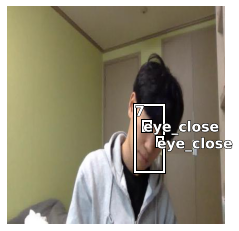

In [ ]:
# img = open_image(path/'train'/train_images[1])
# bbox = ImageBBox.create(*img.size, train_lbl_bbox[1][0], [0,1,1], classes=['7', 'eye_close'])
# #3번째 인덱스는 라벨로 classes에 있는 명을 사용하여 인덱스로 표현할 수 있다.
# #https://fastai1.fast.ai/vision.image.html#Image.show
# #위 링크에서 자세한 설명을 볼 수 있다. img.show 메소드
# img.show(figsize = (6,4),y=bbox)

# #위 셀에서 알아낸 정보를 통해서 imagebbox를 만들 수 있다 -> bounding box를 의미한다. 

And if we apply a transform to our image and the `ImageBBox` object, they stay aligned:

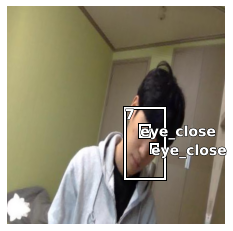

In [ ]:
# img = img.rotate(-10)
# bbox = bbox.rotate(-10)
# img.show(figsize=(6,4), y=bbox)

We group all the image filenames and annotations together, to use the data block API to load the dataset in a `DataBunch`.

In [ ]:
images, lbl_bbox = train_images + val_images,train_lbl_bbox + val_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
#처음에는 따로 받았지만 갑자기 합쳐주네..? 뭐야 ㅋㅋ 나눌필요없겠다
get_y_func = lambda o:img2bbox[o.name]
#마지막으로 이미지와 바운딩박스 라벨을 사전형으로 합쳤고 이 자료형 img2bbox를 뽑아내는 함수가 get_y_func다


#이건 소연님코드인데도움될거같아서잠깐넣어둠
#밑에껄로바꾸면 에러안남!
# def get_y_func(o):
#     filename = o.name
#     if img2bbox.get(o.name):
#         return img2bbox[o.name]
#     else:
#         # 데이터가 다 잘 들어간걸 확인했는데도 자꾸 오류가 나서 넣은 코드
#         # 라벨링이 안된 사진이 들어갔을때 나는 오류라서
#         # 임의로 bbox 리턴. 데이터 교체하면 오류 없을것.
#         return [[[128, 148, 290, 217.5], [152, 162, 170.5, 178]], ['4', 'eye_open']]
#         #이거때문이였어

In [ ]:
# 모든 이미지와 annotations를 모아서 , datablock을 사용하여 dataset을 databunch안에 적재하고자 한다.

def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_files(val_images)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)
    
#여기서 bs는 batch size로 64로 하게 되면 너무 큰 숫자다.

In [ ]:
# # 모든 이미지와 annotations를 모아서 , datablock을 사용하여 dataset을 databunch안에 적재하고자 한다.
# #실험용
# path_test = Path('arbitaryset')

# get_y_func_test = lambda o:[[[128, 148, 290, 217.5], [152, 162, 170.5, 178]], ['4', 'eye_open']]

# def get_data_test(bs, size):
#     src = ObjectItemList.from_folder(path_test/'arbitary')
#     src = src.split_none()
#     src = src.label_from_func(get_y_func_test)
#     src = src.transform(get_transforms(), size=size, tfm_y=True)
#     return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)
  
# #여기서 bs는 batch size로 64로 하게 되면 너무 큰 숫자다.

# data_test = get_data_test(1,128)

In [ ]:
data = get_data(32,128)
#데이터를 불러보자. 여기서 bs의 역할은 모르겠다. 

#data에 대해서 알기위해서 databunch가 어떤 역할을 하는 지 알아보자.
#https://fastai1.fast.ai/basic_data.html#DataBunch

# data = (ObjectItemList.from_folder(coco)
#         #Where are the images? -> in coco and its subfolders
#         .split_by_rand_pct()                          
#         #How to split in train/valid? -> randomly with the default 20% in valid
#         .label_from_func(get_y_func)
#         #How to find the labels? -> use get_y_func on the file name of the data
#         .transform(get_transforms(), tfm_y=True)
#         #Data augmentation? -> Standard transforms; also transform the label images
#         .databunch(bs=16, collate_fn=bb_pad_collate))   
#         #Finally we convert to a DataBunch, use a batch size of 16,
#         # and we use bb_pad_collate to collate the data into a mini-batch

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


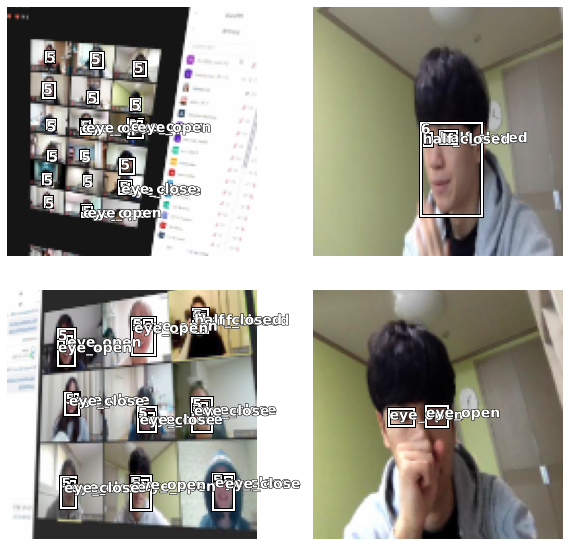

In [ ]:
data.show_batch(rows=2)

## Model

The architecture we will use is a [RetinaNet](https://arxiv.org/abs/1708.02002), which is based on a [Feature Pyramid Network](https://arxiv.org/abs/1612.03144). 

![Retina net](https://github.com/s0ye0nyang/peoplespace-group-B/blob/main/images/retinanet.png?raw=1)

This is a bit like a Unet in the sense we have a branch where the image is progressively reduced then another one where we upsample it again, and there are lateral connections, but we will use the feature maps produced at each level for our final predictions. Specifically, if we start with an image of size (256,256), the traditional resnet has intermediate features maps of sizes:
- C1 (128, 128)  
- C2 (64, 64)
- C3 (32, 32)
- C4 (16, 16)
- C5 (8, 8)
To which the authors add two other features maps C6 and C7 of sizes (4,4) and (2,2) by using stride-2 convolutions. (Note that the model requires an image size of 128 at the minimum because of this.)

Then we have P7 = C7 and we go down from P7 to P2 by upsampling the result of the previous P-layer and adding a lateral connection. The idea is that the last feature map P7 will be responsible to detect big objects, while one like P3 will be responsible to detect smaller objects. 

Each P-something feature map then goes through two subnet of four convolutional layers (with the same weights for all the feature maps), one that will be responsible for finding the category of the object and the other for drawing the bounding box. Each location in the feature map is assigned a given number of anchors (see below) so the classifier ends up with `n_anchors * n_classes` channels and the bounding box regressor with `n_anchors * 4` channels.

In [ ]:
#Grab the convenience functions that helps us buil the Unet
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

In [ ]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [ ]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

        #많은 예측을 한다. 

The model is a bit complex, but that's not the hardest part. It will spit out an absurdly high number of predictions: for the features P3 to P7 with an image size of 256, we have `32*32 + 16*16 + 8*8 + 4*4 +2*2` locations possible in one of the five feature maps, which gives 1,364 possible detections, multiplied by the number of anchors we choose to attribute to each location (9 below), which makes 12,276 possible hits.

A lot of those aren't going to correspond to any object in the picture, and we need to somehow match all those predictions to either nothing or a given bounding box in the picture.

## "Encore" boxes

If we look at the feature map of size `4*4`, we have 16 locations numbered like below: 

In [ ]:
torch.arange(0,16).long().view(4,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

The most basic way to map one of these features with an actual area inside the image is to create the regular 4 by 4 grid. Our convention is that `y` is first (like in numpy or PyTorch), and that all coordinates are scaled from -1 to 1 (-1 being top/right, 1 being bottom/left). 

In [ ]:
#이 피쳐들을 실제 이미지와 매핑하기 위해서는 4곱하기4그리드를 만들어야한다.
#

def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

Let's use a helper function to draw those anchors:

In [ ]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

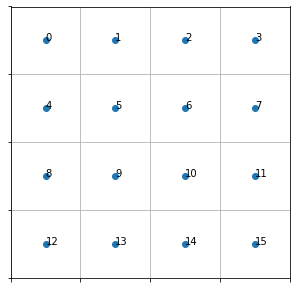

In [ ]:
size = (4,4)
show_anchors(create_grid(size), size)

In practice, we use different ratios and scales of that basic grid to build our anchors, because bounding boxes aren't always a perfect square inside a grid. 

In [ ]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [ ]:
anchors.size()

torch.Size([3069, 4])

That's a bit less than in our computation earlier, but this is because it's for the case of (128,128) images (sizes go from (1,1) to (32,32) instead of (2,2) to (64,64)).

In [ ]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

Here is an example of the 9 anchor boxes with different scales/ratios on one region of the image. Now imagine we have this at every location of each of the feature maps.

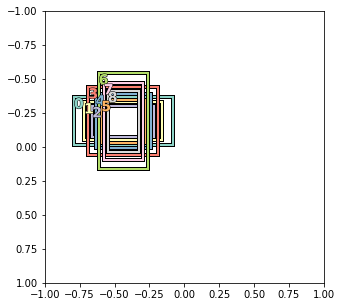

In [ ]:
show_boxes(anchors[900:909])

For each anchor, we have one class predicted by the classifier and 4 floats `p_y,p_x,p_h,p_w` predicted by the regressor. If the corresponding anchor as a center in `anc_y`, `anc_x` with dimensions `anc_h`, `anc_w`, the predicted bounding box has those characteristics:
```
center = [p_y * anc_h + anc_y, p_x * anc_w + anc_x]
height = anc_h * exp(p_h)
width  = anc_w * exp(p_w)
```
The idea is that a prediction of `(0,0,0,0)` corresponds to the anchor itself.

The next function converts the activations of the model in bounding boxes.

In [ ]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

Here is an example with the 3 by 4 regular grid and random predictions.

In [ ]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)

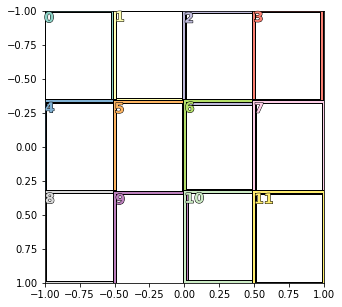

In [ ]:
show_boxes(bboxes)

This helper function changes boxes in the format center/height/width to top/left/bottom/right.

In [ ]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

Now to decide which predicted bounding box will match a given ground truth object, we will compute the intersection over unions ratios between all the anchors and all the targets, then we will keep the ones that have an overlap greater than a given threshold (0.5).

In [ ]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

Let's see some results, if we have our 12 anchors from before...

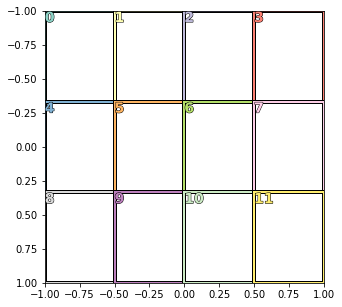

In [ ]:
show_boxes(anchors)

... and those targets (0. is the whole image)

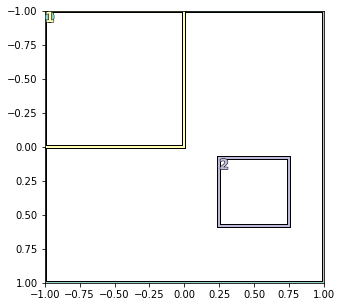

In [ ]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

Then the intersections of each bboxes by each targets are:

In [ ]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [ ]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

And then the IoU values are.

In [ ]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

Then we match a anchor to targets with the following rules:
- for each anchor we take the maximum overlap possible with any of the targets.
- if that maximum overlap is less than 0.4, we match the anchor box to background, the classifier's target will be that class
- if the maximum overlap is greater than 0.5, we match the anchor box to that ground truth object. The classifier's target will be the category of that target
- if the maximum overlap is between 0.4 and 0.5, we ignore that anchor in our loss computation
- optionally, we force-match for each ground truth object the anchor that has the maximum overlap with it (not sure it helps)

In [ ]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In our previous example, no one had an overlap > 0.5, so unless we use the special rule commented out, there are no matches.

In [ ]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

With anchors very close to the targets.

In [ ]:
# size=(3,4)
# anchors = create_grid(size)
# anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
# activations = 0.1 * torch.randn(size[0]*size[1], 4)
# bboxes = activ_to_bbox(activations, anchors)
# match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

With anchors in the grey area.

In [ ]:
# anchors = create_grid((2,2))
# anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
# targets = anchors.clone()
# anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
# match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

Does the opposite of `cthw2tbr`.

In [ ]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

Does the opposite of `activ_to_bbox`.

In [ ]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

We will one-hot encode our targets with the convention that the class of index 0 is the background, which is the absence of any other classes. That is coded by a row of zeros.

In [ ]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [ ]:
# encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

And now we are ready to build the loss function. It has two parts, one for the classifier and one for the regressor. For the regression, we will use the L1 (potentially smoothed) loss between the predicted activations for an anchor that matches a given object (we ignore the no match or matches to background) and the corresponding bounding box (after going through `bbox2activ`).

For the classification, we use the focal loss, which is a variant of the binary cross entropy used when we have a lot imbalance between the classes to predict (here we will very often have to predict 'background').

In [ ]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

This is a variant of the L1 loss used in several implementations:

In [ ]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

## Defining the Learner

In [ ]:
# ratios = [1/2,1,2]
# scales = [1,2**(-1/3), 2**(-2/3)]
# # scales = [1,2**(1/3), 2**(2/3)]

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
# scales = [1,2**(1/3), 2**(2/3)]

#resnet50으로부터 retinanet을 만든다.
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

torch.sigmoid(tensor([-4.]))

def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

learn = learn.split(retina_net_split)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Why `final_bias=-4`? That's because we want the network to predict background easily at the beginning (since it's the most common class). At first the final convolution of the classifier is initialized with weights=0 and that bias, so it will return -4 for everyone. If go though a sigmoid 

In [ ]:
# torch.sigmoid(tensor([-4.]))

tensor([0.0180])

We see it'll give a corresponding probability of 0.02 roughly. 

Then, for transfer learning/discriminative LRs, we need to define how to split between body and custom head.

In [ ]:
# def retina_net_split(model):
#     groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
#     return groups + [list(model.children())[1:]]

In [ ]:
# learn = learn.split(retina_net_split)

And now we can train as usual!

In [ ]:
# learn.freeze()

In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot(skip_end=5)

In [ ]:
# learn.fit_one_cycle(1, 9e-5)

In [ ]:
# learn.save('stage1-128')

In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(4, 1e-4)

In [ ]:
# learn.unfreeze()

In [ ]:
# learn.save('stage2-128')
# #첫번째 모델

In [ ]:
#새로운 함수를 사용해보자!

# learn.data = get_data(64,128)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,time
0,3.524985,#na#,02:54
1,3.032653,#na#,00:25


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.20E-04


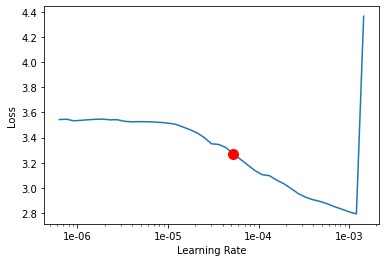

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, 5.25e-05)

epoch,train_loss,valid_loss,time
0,3.372687,2.539701,00:34
1,2.700585,1.927649,00:26
2,2.190844,1.352088,00:26
3,1.784582,1.167783,00:25
4,1.503005,1.139596,00:26
5,1.281468,1.018657,00:26
6,1.113382,0.931778,00:25
7,0.988179,0.910851,00:26
8,0.891956,0.925751,00:26
9,0.827735,0.899456,00:26


In [ ]:
learn.save('stage1-192')
# 'stage2-128'
# learn.save('stage1-256')

In [ ]:
# learn.unfreeze()

In [ ]:
# learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [ ]:
# learn.save('stage2-192')

In [ ]:
# learn.data = get_data(24,256)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# learn.freeze()
# learn.fit_one_cycle(5, 1e-4)

In [ ]:
# learn.save('stage1-256')

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [ ]:
# learn.save('stage2-256')

## Results

In [ ]:
learn.export(file = 'export_lm.pkl')

In [ ]:
learn = learn.load('stage1-192')
#dls = DataLoaders(tdl,tdl)

# learn.save('stage1-192')
# 'stage2-128'
# learn.save('stage1-256')

In [ ]:
# img,target = next(iter(data.valid_dl))
# with torch.no_grad():
#     output = learn.model(img)

First we need to remove the padding that was added to collate our targets together.

In [ ]:
# def unpad(tgt_bbox, tgt_clas, pad_idx=0):
#     i = torch.min(torch.nonzero(tgt_clas-pad_idx))
#     return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

Then we process the outputs of the model: we convert the activations of the regressor to bounding boxes and the predictions to probabilities, only keeping those above a given threshold.

In [ ]:
# def process_output(output, i, detect_thresh=0.25):
#     "Process `output[i]` and return the predicted bboxes above `detect_thresh`."
#     clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
#     anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
#     bbox_pred = activ_to_bbox(bbox_pred, anchors)
#     clas_pred = torch.sigmoid(clas_pred)
#     detect_mask = clas_pred.max(1)[0] > detect_thresh
#     bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
#     bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
#     scores, preds = clas_pred.max(1)
#     return bbox_pred, scores, preds

Helper functions to plot the results

In [ ]:
# def _draw_outline(o:Patch, lw:int):
#     "Outline bounding box onto image `Patch`."
#     o.set_path_effects([patheffects.Stroke(
#         linewidth=lw, foreground='black'), patheffects.Normal()])

# def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
#     "Draw bounding box on `ax`."
#     patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
#     _draw_outline(patch, 4)
#     if text is not None:
#         patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
#         _draw_outline(patch,1)

In [ ]:
# def show_preds(img, output, idx, detect_thresh=0.25, classes=None):
#     bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
#     bbox_pred, preds, scores = bbox_pred.cpu(), preds.cpu(), scores.cpu()
#     t_sz = torch.Tensor([*img.size])[None].float()
#     bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
#     bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
#     bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
#     bbox_pred = bbox_pred.long()
#     _, ax = plt.subplots(1,1)
#     for bbox, c, scr in zip(bbox_pred, preds, scores):
#         img.show(ax=ax)
#         txt = str(c.item()) if classes is None else classes[c.item()+1]
#         draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

And let's have a look at one picture.

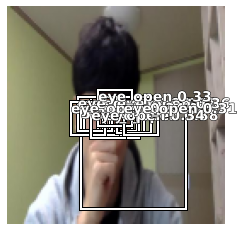

In [ ]:
# idx = 1
# img = data.valid_ds[idx][0]
# show_preds(img, output, idx, detect_thresh=0.3, classes=data.classes)

It looks like a lot of our anchors are detecting kind of the same object. We use an algorithm called Non-Maximum Suppression to remove near-duplicates: going from the biggest score predicted to the lowest, we take the corresponding bounding boxes and remove all the bounding boxes down the list that have an IoU > 0.5 with this one. We continue the process until we have reached the end of the list.

In [ ]:
# def nms(boxes, scores, thresh=0.3):
#     idx_sort = scores.argsort(descending=True)
#     boxes, scores = boxes[idx_sort], scores[idx_sort]
#     to_keep, indexes = [], torch.LongTensor(range_of(scores))
#     while len(scores) > 0:
#         to_keep.append(idx_sort[indexes[0]])
#         iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
#         mask_keep = iou_vals < thresh
#         if len(mask_keep.nonzero()) == 0: break
#         boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
#     return LongTensor(to_keep)

# def process_output(output, i, detect_thresh=0.25):
#     clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
#     anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
#     bbox_pred = activ_to_bbox(bbox_pred, anchors)
#     clas_pred = torch.sigmoid(clas_pred)
#     detect_mask = clas_pred.max(1)[0] > detect_thresh
#     bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
#     bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
#     if clas_pred.numel() == 0: return [],[],[]
#     scores, preds = clas_pred.max(1)
#     return bbox_pred, scores, preds

# def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
#     bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
#     if len(scores) != 0:
#         to_keep = nms(bbox_pred, scores)
#         bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
#         t_sz = torch.Tensor([*img.size])[None].float()
#         bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
#         bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
#         bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
#         bbox_pred = bbox_pred.long()
#     if ax is None: _, ax = plt.subplots(1,1)
#     img.show(ax=ax)
#     for bbox, c, scr in zip(bbox_pred, preds, scores):
#         txt = str(c.item()) if classes is None else classes[c.item()+1]
#         draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')
# def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
#     x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
#     print(x)
#     print(y)
#     with torch.no_grad():
#         z = learn.model.eval()(x)
#     _,axs = plt.subplots(n, 2, figsize=figsize)
#     for i in range(n):
#         img,bbox = learn.data.valid_ds[start+i]
#         img.show(ax=axs[i,0], y=bbox)
#         show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])

In [ ]:
# path_test = Path('arbitaryset')

# get_y_func_test = lambda o:[[[128, 148, 290, 217.5], [152, 162, 170.5, 178]], ['4', 'eye_open']]

# data_test = get_data_test(1,128)


# 완전 중요한 predict를 위한 함수들,, 야매로 만들어서 절대로 빼먹으면 안돼요.

def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def get_data_test(bs, size):
    src = ObjectItemList.from_folder(path_test/'arbitary')
    src = src.split_none()
    src = src.label_from_func(get_y_func_test)
    #src = src.transform(get_transforms(), size=size, tfm_y=False)
    return src.databunch(path=path_test, bs=bs, collate_fn=bb_pad_collate)

def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    bbox_real = 0
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')
        bbox_real = bbox
    return bbox_real

def predict(x,learn):
  #기존에 있던 파일 없애는 것 연구하기.
  path_test = Path("'"+x+"'")
  get_y_func_test = lambda o:[[[128, 148, 290, 217.5], [152, 162, 170.5, 178]], ['4', 'eye_open']]
  data_test = get_data_test(1,128)
  x,y = data_test.one_batch(DatasetType.Train, cpu=False)
  start=0
  n=1
  detect_thresh=0.35
  figsize=(10,10)
  with torch.no_grad():
      z = learn.model.eval()(x)
  _,axs = plt.subplots(n, 1, figsize=figsize)
  img,bbox = data_test.train_ds[0]
  bbox = show_preds(img, z, 0, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs)
  print(bbox)

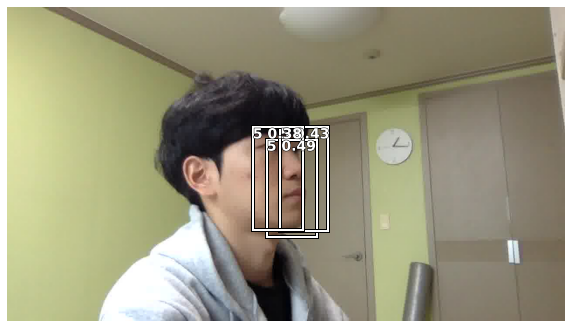

In [ ]:
# learn = learn.load('stage1-192')
predict('arbitaryset',learn)

## mAP

A metric often used for this kind of task is the mean Average Precision (our mAP). It relies on computing the cumulated precision and recall for each class, then tries to compute the area under the precision/recall curve we can draw.

In [ ]:
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [ ]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [ ]:
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [ ]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1)

In [ ]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')

In [ ]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')

In [ ]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')

In [ ]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')

In [ ]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')